**CS 481 Final Project**

The goal of this project is to classify tweets from members of U.S. congress by their political party. 

The file ['party_tweets.csv'](https://github.com/GeorgeIIT/cs481project/blob/main/party_tweets.csv) contains tweets and retweets from members of the US Congress. Each tweet is labeled with the congress member's party affiliation. The partys are Democrats and Republicans, Members of a third party were not included. Tweets were collected by pulling the last 40 tweets (retweets included) from each congress member's user timeline on 4/1/21. The goal for this repository is to predict the political party of a legislator based on the content they share online. It should be noted that these are official twitter accounts so the vast majority of the content posted is relevant to the user's political career. Models trained with this dataset may not be effective for predicting the party affiliation of non-political content, or political content from perspectives outside of the United States.

  * Total tweets: 21181
  * Democrat Tweets (D): 10956
  * Republican Tweets (R): 10225
  * Ratio: 52:48 D:R

The code used for collecting the twitter data is in ['Get_congress_tw_data.py'](https://github.com/GeorgeIIT/cs481project/blob/main/Get_congress_tw_data.py). If you wish to run it, you will need to provide your own twitter authentication tokens. Also be warned that it takes several hours to run because of the rate limit for twitter API calls.

Congress member twitter handles were found on [Triage Cancer's](https://triagecancer.org/congressional-social-media) website.

**Libraries Used**

In [84]:
#Data Representation
import numpy as np
import pandas as pd
import string

#Preprocessing Text
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

#Vector Representaion
from sklearn.feature_extraction.text import CountVectorizer

#Train/Test Split
from sklearn.model_selection import train_test_split

#Logistic Regression Algorithm
from sklearn.linear_model import LogisticRegression

#Performance Evaluation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

#Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#Plotting (used to explore the data and evaluate model performance)
import matplotlib.pyplot as plt

**Load the Data - For use in google colab**


In [ ]:
#Retreiving dataset From File Explorer (for running on google collab)
from google.colab import files
import io

#import the dataset
uploaded = files.upload()

In [ ]:
#read in the data as a pandas dataframe, pipes (|) were used as delimiters. 
data = pd.read_csv(io.BytesIO(uploaded['party_tweets.csv']),sep='|',engine='python',encoding='utf-8',quoting=3)
#make sure pandas does not truncate display
pd.set_option('display.max_colwidth', None)
data.shape, display(data.head())

**Load the Data - For use in jupyter notebooks**

In [99]:
data = pd.read_csv('party_tweets.csv',sep='|',engine='python',encoding='utf-8',quoting=3)

**Exploring the Data**

empty cells:
idx      0
tweet    0
party    0
dtype: int64

Shape before dropping duplicates:
(21181, 3)
Shape after dropping duplicates:
(21171, 3)

Distribution of classes:
D    10956
R    10215
Name: party, dtype: int64

Tweet charechter length info:
count    21171.000000
mean       199.856407
std         74.196388
min          3.000000
25%        148.000000
50%        220.000000
75%        262.000000
max        735.000000
Name: length, dtype: float64


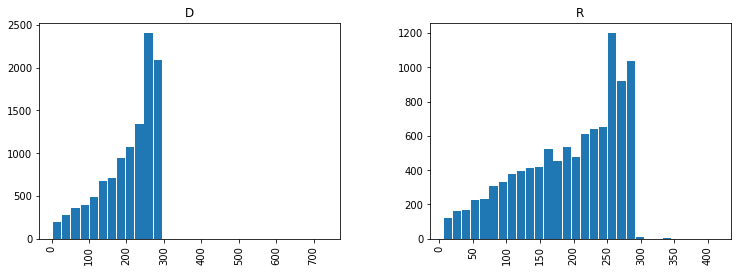

In [100]:
#check empty cells (should be 0 for this dataset)
print("empty cells:\n{}".format(data.isnull().sum()))

#drop duplicate entries, this data set happens to have 10
print("\nShape before dropping duplicates:\n{}".format(data.shape))
data = data.drop_duplicates(keep="first")
print("Shape after dropping duplicates:\n{}".format(data.shape))

#dropping the index given in the .csv file so it is not confused wit hthe pandas index 
data = data.drop(['idx'],axis=1)

#data is sorted by legislator in 40 tweet chunks, we need to shuffle them and reset the index
data = data.sample(frac=1, random_state=13).reset_index(drop=True)

#check the balance of the data
print("\nDistribution of classes:\n{}".format(data.party.value_counts()))

#take a look at the length of the tweets, this also adds a new column to the dataset
data['length'] = data['tweet'].apply(len)
print("\nTweet charechter length info:\n{}".format(data['length'].describe()))

#get a visualization of the length distribution by party
data.hist(column='length',by='party',bins=30,figsize=(12,4),rwidth=0.9)
plt.show()


You can see above that most tweets max out at 280 charecters, Twitter's current charecter limit. There are a few outliers that changed the scale of the two graphs though. These posts were able to excceed the limit becuase they're actually one or more retweets combined together. 

**Preprocessing the Data**

These three functions are going to be used to clean up the data. Mainly expanding contractions and removing special charecters. But the last one converts the party label from D and R to 0 and 1 respectively. 

In [101]:
def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime 
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []
    
    for tweet_text in tqdm(df['tweet']):
        
        # expand the contracted words
        tweet_text = decontracted(tweet_text)
        
        #remove html tags
        tweet_text = BeautifulSoup(tweet_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        tweet_text = re.sub("[^a-zA-Z]"," ", tweet_text)
    
        #the urls from tweets were replaced with '<weblink>', get rid of them here
        tweet_text = tweet_text.replace('<weblink>', '')
        
        #removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        tweet_text = tweet_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        #remove emails
        tweet_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', tweet_text)
        
        cleaned_review.append(tweet_text)

    return cleaned_review

def convert_party_to_number(df):
    converted_label = []
    for numeric_party in df['party']:
        if(numeric_party == 'D'):
            numeric_party = 0
        else:
            numeric_party = 1
        converted_label.append(numeric_party)
    return converted_label

In [102]:
data['cleaned_tweet'] = clean_text(data)
data['numeric_party'] = convert_party_to_number(data)

100%|██████████████████████████████████████████████████████████████████████████| 21171/21171 [00:09<00:00, 2252.35it/s]


Data after cleaning

In [103]:
data.shape, display(data.head())

,tweet,party,length,cleaned_tweet,numeric_party
0,From top to bottom #HR1 is a bad idea <webLink>,R,47,From top to bottom HR is a bad idea,1
1,Great news for our small biz in SW MI! Republi...,R,204,Great news for our small biz in SW MI Republi...,1
2,I testified to the House Ways and Means Commit...,D,167,I testified to the House Ways and Means Commit...,0
3,Happy Palm Sunday to those who observe. May th...,R,111,Happy Palm Sunday to those who observe May th...,1
4,“A government that robs Peter to pay Paul can ...,R,105,A government that robs Peter to pay Paul can ...,1


((21171, 5), None)

Below is the set of stopwords that will be ignored by the count vectorizer. 

In [104]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't","no","nor","not"])

**Vectorizing The Data**

In [106]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords,max_df=0.6,min_df=1,ngram_range=(1,2))
#convert the celaned tweets into vectors, store them in X. Party labels stored in Y
X = vectorizer.fit_transform(data['cleaned_tweet'])
Y = data['numeric_party']
#print(X.toarray()[0])
print("Vector Shape:\t\t", X.shape)
print("Party Label Shape:\t", Y.shape)

Vector Shape:		 (21171, 251311)
Party Label Shape:	 (21171,)


**Train Test Split** 

Here I used an 80% training and 20% testing split to partition the data. 

In [107]:
train_idx, test_idx = train_test_split(np.arange(data.shape[0]), test_size=0.25, shuffle=True, random_state=42)

#show split
print("Number of training examples:\t", len(train_idx))
print("Number of testing examples:\t", len(test_idx))

#train/test split the data
X_train = X[train_idx]
Y_train = Y[train_idx]
X_test = X[test_idx]
Y_test = Y[test_idx]

#show shape of each partition
print("\nTraining data:\nX: {}, Y: {}".format(X_train.shape,Y_train.shape))
print("\nTesting data:\nX: {}, Y: {}".format(X_test.shape,Y_test.shape))

Number of training examples:	 15878
Number of testing examples:	 5293

Training data:
X: (15878, 251311), Y: (15878,)

Testing data:
X: (5293, 251311), Y: (5293,)


**Fitting the Logistic Regreassion**

In [108]:
#fit the logistic regression
lr_clf = LogisticRegression(max_iter=1000,solver='lbfgs',penalty='l2')
lr_clf.fit(X_train, Y_train)
y_pred_test = lr_clf.predict(X_test)
y_predprob_test = lr_clf.predict_proba(X_test)

**Evaluating Performance**

First looking at the classification report

In [109]:
#check out how well the model performed
print("Classification Report:\n", classification_report(Y_test, y_pred_test))
scores = cross_val_score(lr_clf, X, Y, cv=4, scoring='f1')
print("Cross Validation Score:\n",scores)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      2804
           1       0.78      0.83      0.81      2489

    accuracy                           0.81      5293
   macro avg       0.81      0.81      0.81      5293
weighted avg       0.81      0.81      0.81      5293

Cross Validation Score:
 [0.81169456 0.82014388 0.81969756 0.81296081]


Now the ROC curve

Note that republicans were chosen as the "positive" label. This was an arbitrary decision following the labels 0 and 1 for D and R.  

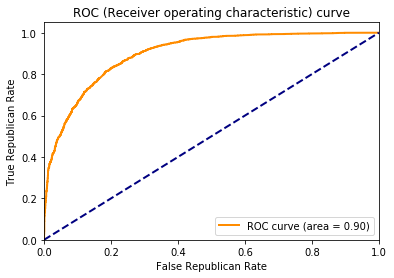

In [110]:
fpr, tpr, thresholds = roc_curve(y_true = Y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Republican Rate')
plt.ylabel('True Republican Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

**Parameter Tuning with Grid Search**

In [111]:
vectorizer = CountVectorizer(lowercase=True,stop_words=stopwords)
logistic = LogisticRegression(max_iter=1000,solver='lbfgs')

#build a pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),
                         ('classifier',logistic)])

#dictionary for model params and corresponding values
param_grid = {
    'vectorizer__min_df':[1,2,3],
    'vectorizer__max_df':[0.6,0.7,0.8],
    'vectorizer__ngram_range':[(1,1),(1,2),(2,2),(1,3)],
    'classifier__penalty':['none','l2']
}

search_result = GridSearchCV(pipe,param_grid,cv=4,scoring='f1',n_jobs=6).fit(data.cleaned_tweet.values, data.numeric_party.values)

print("Best parameter (CV score = %0.3f):" % search_result.best_score_)
print(search_result.best_params_)

Best parameter (CV score = 0.816):
{'classifier__penalty': 'l2', 'vectorizer__max_df': 0.6, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}


Top features for each party

In [49]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("\nTop party 1 features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:15]):
    print(item)

# most of the words are reliable evidence of indicating negative sentiments
print("\nTop party 0 features:")
for item in (sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:15]):
    print(item)
    
    


Top party 1 features:
('realdonaldtrump', 2.271)
('bidenbordercrisis', 2.247)
('china', 1.635)
('democrats', 1.599)
('border', 1.59)
('ccp', 1.571)
('utpol', 1.375)
('god', 1.369)
('idaho', 1.321)
('get vote', 1.31)
('partisan', 1.301)
('pelosi', 1.291)
('ohio', 1.272)
('nuclear', 1.263)
('alaska', 1.242)

Top party 0 features:
('americanrescueplan', -3.594)
('stopasianhate', -2.197)
('az', -1.758)
('nj', -1.534)
('dcstatehood', -1.526)
('buildbackbetter', -1.462)
('chair', -1.449)
('msnbc', -1.417)
('democracy', -1.384)
('invest', -1.372)
('forthepeople', -1.34)
('sameach happy', -1.34)
('guam', -1.322)
('black', -1.278)
('transgender', -1.272)
